In [37]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.python.platform.build_info import build_info
from tensorflow.config.experimental import list_physical_devices, VirtualDeviceConfiguration, set_virtual_device_configuration #type:ignore

from tensorflow.keras.regularizers import l2 #type:ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD #type:ignore
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #type:ignore
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, LeakyReLU, AveragePooling2D #type:ignore
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model #type:ignore

from tensorflow.keras.losses import Loss #type:ignore
from tensorflow.keras import backend as K #type:ignore
from tensorflow.keras.losses import CategoricalFocalCrossentropy #type:ignore
from sklearn.utils.class_weight import compute_class_weight

from pathlib import Path
import os
import shutil
import random

In [38]:
params = {
    'filters': 32,
    'conv_layers': 4,
    'dense_units': 128,
    'dropout': 0.30,
    'batch_norm': True,
    'optimizer': "adam",
    'lr': 1e-3,
    'flattening_layers': "GAP2D",
    'random_state': 42
}

In [39]:
current_dir = Path(os.getcwd())

data_dir = current_dir.parent / "data"

train_dir = data_dir / "train"
val_dir = data_dir / "valid"
test_dir = data_dir / "test"

model_name = "Sequential_Model"
checkpoints_dir = current_dir.parent / "checkpoints" / model_name
checkpoints_dir.mkdir(parents=True, exist_ok=True)

checkpoint_file_name = model_name + "-1.h5"

print(f"{'Project Root:':<25}{current_dir.parent}")
print(f"{'Train Directory:':<25}{train_dir}")
print(f"{'Validation Directory:':<25}{val_dir}")
print(f"{'Test Directory:':<25}{test_dir}")
print(f"{'Checkpoints Directory:':<25}{checkpoints_dir}")
print(f"{'Checkpoint File Name:':<25}{checkpoint_file_name}")

Project Root:            c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier
Train Directory:         c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\train
Validation Directory:    c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\valid
Test Directory:          c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\test
Checkpoints Directory:   c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\Sequential_Model
Checkpoint File Name:    Sequential_Model-1.h5


In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.08,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

Found 2637 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 290 images belonging to 9 classes.


In [41]:
class_labels = train_generator.classes
class_weight_dict = dict(
    enumerate(
        compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
    )
)
class_weight_dict

{0: np.float64(4.883333333333334),
 1: np.float64(0.9301587301587302),
 2: np.float64(0.9242902208201893),
 3: np.float64(0.9301587301587302),
 4: np.float64(0.9099378881987578),
 5: np.float64(0.846820809248555),
 6: np.float64(0.9361022364217252),
 7: np.float64(0.8772455089820359),
 8: np.float64(0.9301587301587302)}

In [ ]:
modelcheckpoint = ModelCheckpoint(str(checkpoints_dir / checkpoint_file_name), monitor="val_loss", save_best_only=True, verbose=0)

callbacks = [
    modelcheckpoint,
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.33, patience=2, min_lr=1e-6)
]

model = Sequential()
filters = params['filters']
for i in range(params['conv_layers']):
    if i == 0:
        model.add(Conv2D(filters, (3,3), activation='relu',kernel_regularizer=l2(0.001) ,input_shape=(64, 64, 3)))
    else:
        model.add(Conv2D(filters, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    if params['batch_norm']:
        model.add(BatchNormalization())
    filters *= 2  # Double filters each block
    
if params["flattening_layers"] == "GAP2D":
    model.add(GlobalAveragePooling2D())
    model.add(Dense(params['dense_units'], activation='relu', kernel_regularizer=l2(0.001)))
else:
    model.add(Flatten())
    model.add(Dense(params['dense_units'], activation='relu'))
    
model.add(Dropout(params['dropout']))
model.add(Dense(train_generator.num_classes, activation='softmax'))

if params['optimizer'] == 'adam':
    opt = Adam(learning_rate=params['lr'])
elif params['optimizer'] == 'rmsprop':
    opt = RMSprop(learning_rate=params['lr'])
else:
    opt = SGD(learning_rate=params['lr'], momentum=0.9)
    

model.compile(
    optimizer=opt, 
    loss=CategoricalFocalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,393 (1.62 MB)

 Trainable params: 423,433 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [44]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.1922 - loss: 0.6447

83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 535ms/step - accuracy: 0.2332 - loss: 0.5776 - val_accuracy: 0.1132 - val_loss: 0.7484 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 534ms/step - accuracy: 0.3648 - loss: 0.4472 - val_accuracy: 0.1434 - val_loss: 0.8306 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 532ms/step - accuracy: 0.4327 - loss: 0.3885 - val_accuracy: 0.1053 - val_loss: 0.9942 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 510ms/step - accuracy: 0.5165 - loss: 0.3337 - val_accuracy: 0.1066 - val_loss: 0.9674 - learning_rate: 3.3000e-04
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 545ms/step - accuracy: 0.5347 - loss: 0.3155 - val_accuracy: 0.1132 - val_loss: 0.9039 - learning_rate: 3.3000e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 515ms/step - accuracy: 0.5976 - loss: 0.2896 - val_accuracy: 0.1579 - val_loss: 0.8160 - learning_rate: 1.0890e-04
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5733 - loss: 0.

83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 522ms/step - accuracy: 0.5950 - loss: 0.2832 - val_accuracy: 0.2184 - val_loss: 0.6298 - learning_rate: 1.0890e-04
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6068 - loss: 0.2779

83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 516ms/step - accuracy: 0.6105 - loss: 0.2732 - val_accuracy: 0.4132 - val_loss: 0.4108 - learning_rate: 1.0890e-04
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6158 - loss: 0.2669

83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 517ms/step - accuracy: 0.6280 - loss: 0.2675 - val_accuracy: 0.4789 - val_loss: 0.3542 - learning_rate: 1.0890e-04
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6211 - loss: 0.2608

83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 534ms/step - accuracy: 0.6268 - loss: 0.2610 - val_accuracy: 0.5421 - val_loss: 0.3222 - learning_rate: 1.0890e-04
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 524ms/step - accuracy: 0.6496 - loss: 0.2547 - val_accuracy: 0.5211 - val_loss: 0.3400 - learning_rate: 1.0890e-04
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 534ms/step - accuracy: 0.6568 - loss: 0.2495 - val_accuracy: 0.5105 - val_loss: 0.3392 - learning_rate: 1.0890e-04
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6738 - loss: 0.2413

83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 512ms/step - accuracy: 0.6777 - loss: 0.2397 - val_accuracy: 0.6079 - val_loss: 0.2950 - learning_rate: 3.5937e-05
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 495ms/step - accuracy: 0.6815 - loss: 0.2337 - val_accuracy: 0.5526 - val_loss: 0.3145 - learning_rate: 3.5937e-05
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6519 - loss: 0.2387

83/83 ━━━━━━━━━━━━━━━━━━━━ 47s 570ms/step - accuracy: 0.6750 - loss: 0.2341 - val_accuracy: 0.6211 - val_loss: 0.2782 - learning_rate: 3.5937e-05
Epoch 16/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 514ms/step - accuracy: 0.6852 - loss: 0.2332 - val_accuracy: 0.5789 - val_loss: 0.3013 - learning_rate: 3.5937e-05
Epoch 17/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 507ms/step - accuracy: 0.6887 - loss: 0.2287 - val_accuracy: 0.6000 - val_loss: 0.2924 - learning_rate: 3.5937e-05
Epoch 18/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 45s 544ms/step - accuracy: 0.7050 - loss: 0.2236 - val_accuracy: 0.5816 - val_loss: 0.2993 - learning_rate: 1.1859e-05
Epoch 19/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - accuracy: 0.6883 - loss: 0.2254 - val_accuracy: 0.5895 - val_loss: 0.2936 - learning_rate: 1.1859e-05
Epoch 20/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 515ms/step - accuracy: 0.6921 - loss: 0.2276 - val_accuracy: 0.5921 - val_loss: 0.2947 - learning_rate: 3.9135e-06
Epoch 21/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 511ms/step - accuracy

In [45]:
def evaluate_model(model, test_ds, class_names):
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\nTest Results:\nAccuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

    preds = model.predict(test_ds, verbose=1)
    y_pred = np.argmax(preds, axis=1)

    if hasattr(test_ds, 'labels'):
        y_true = test_ds.labels
    else:
        y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    print('\nClassification Report:\n')
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return test_acc, test_loss, y_pred


Test Results:
Accuracy: 0.6276 | Loss: 0.2606
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step


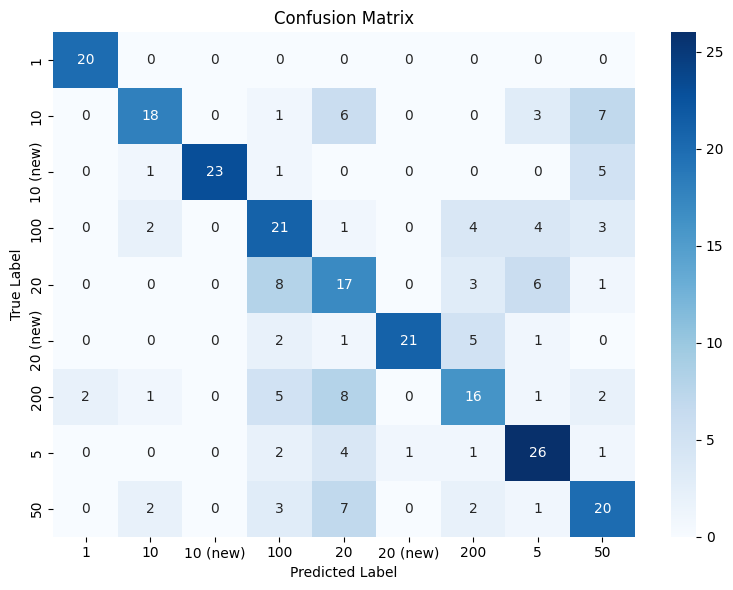


Classification Report:

              precision    recall  f1-score   support

           1     0.9091    1.0000    0.9524        20
          10     0.7500    0.5143    0.6102        35
    10 (new)     1.0000    0.7667    0.8679        30
         100     0.4884    0.6000    0.5385        35
          20     0.3864    0.4857    0.4304        35
    20 (new)     0.9545    0.7000    0.8077        30
         200     0.5161    0.4571    0.4848        35
           5     0.6190    0.7429    0.6753        35
          50     0.5128    0.5714    0.5405        35

    accuracy                         0.6276       290
   macro avg     0.6818    0.6487    0.6564       290
weighted avg     0.6599    0.6276    0.6348       290



In [46]:
test_acc, test_loss, y_pred = evaluate_model(model, test_generator, list(test_generator.class_indices.keys()))

In [47]:
def plot_training_curves(history, test_acc=0):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.axhline(y=test_acc, linestyle='--', color='green', label=f'Test Acc: {test_acc:.2f}')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

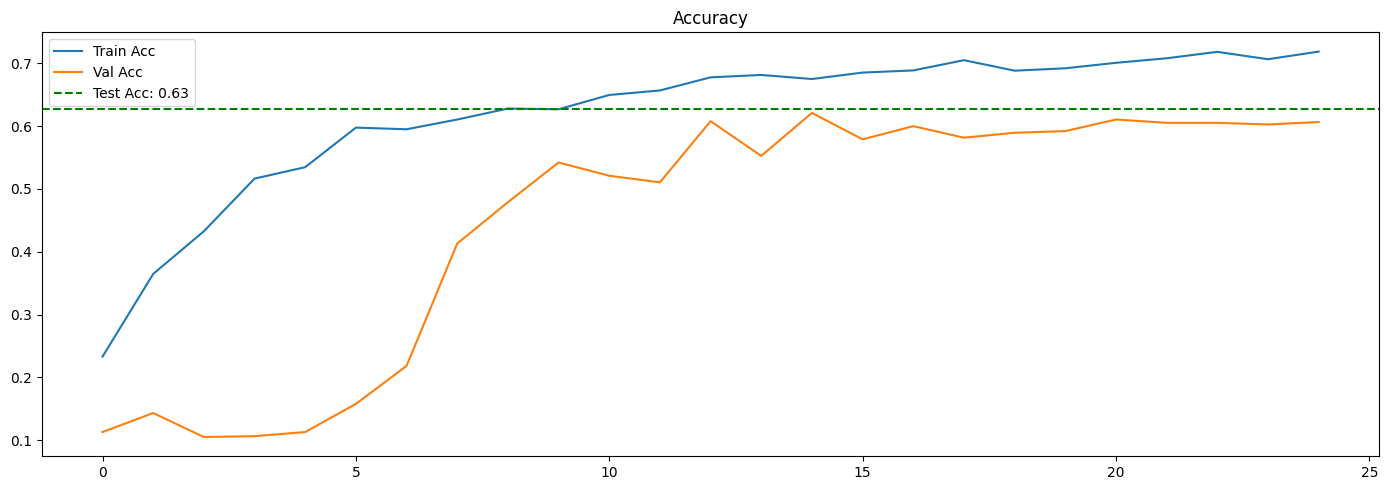

In [48]:
plot_training_curves(history, test_acc=test_acc)